<a href="https://colab.research.google.com/github/guillermocalderon2021/tfm-words-embeddings/blob/main/TransformerArxiv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<h1><font color='#12007a'>Embeddings contextuales </p>



En concreto, vamos a comparar los siguientes transformers, y los aplicaremos a las tareas de clasificación binaria y clasificación multiclase:


In [ ]:
models = ['bert-base-uncased',
          'distilbert-base-uncased',
          'roberta-base',
          'xlnet-base-cased',
          'gpt2', 't5-small']

model_name = models[3]



print(model_name)


xlnet-base-cased


## Instalar librerías

Debemos instalar las librerías de transformers y datasets:

In [ ]:
import torch
torch.__version__

'2.2.1+cu121'

In [ ]:
!pip install -q datasets

In [ ]:
!pip install -q transformers[torch] datasets


Para garantizar la reproductividad de nuestros experimentos vamos a fijar una semilla. Con esto conseguimos que las inicializaciones siempre sean las mismas:

In [ ]:
from transformers import set_seed
set_seed(42)

## Dataset

Vamos a cargar el dataset, tal y como ya hicimos en la primera parte de esta práctica:


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import pandas as pd

os.chdir('/content/drive/My Drive/Colab Notebooks/data/arxiv/')
df = pd.read_csv('cs_papers_api.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,paper_id,title,abstract,year,primary_category,categories
0,2301.02657v1,TarViS: A Unified Approach for Target-based Vi...,The general domain of video segmentation is cu...,2023-01-06 18:59:52+00:00,cs.CV,cs.CV cs.AI cs.LG
1,2301.02642v1,Triple-stream Deep Metric Learning of Great Ap...,We propose the first metric learning system fo...,2023-01-06 18:36:04+00:00,cs.CV,cs.CV cs.AI cs.LG
2,2301.02610v1,Feedback-Gated Rectified Linear Units,Feedback connections play a prominent role in ...,2023-01-06 17:14:11+00:00,cs.NE,cs.NE cs.AI
3,2301.02593v1,Multi-Agent Reinforcement Learning for Fast-Ti...,To integrate high amounts of renewable energy ...,2023-01-06 16:41:51+00:00,cs.MA,cs.MA cs.AI cs.LG cs.SY
4,2301.02561v1,Multi-Vehicle Trajectory Prediction at Interse...,Traditional approaches to prediction of future...,2023-01-06 15:13:23+00:00,cs.RO,cs.RO cs.AI


In [ ]:
df=df[0:20000]
len(df)

20000

# BASELINE

In [ ]:
%%time

import multiprocessing
import spacy
import re
import inspect
import numpy as np
from nltk.stem import PorterStemmer


class BaselinePreprocessor:
    """Here, I'll prepare the data for the multi-label classification of the
    baseline model. This class will preprocess the data in a parallel matter using
    multiple processes. The original DataFrame will be split in chunks. A pipeline
    of transformations will be ran on each chunk.
    The pipeline of transformations will include:
    - Text lowercasing
    - Special symbols removal
    - Stopwords removal
    - Stemming (It is chosen for simplicity's sake, using lemmatization will be more resource intensive)

    Args:
        dataset (pandas.DataFrame): The dataset in a DataFrame format.
    """

    def __init__(self, dataset: pd.DataFrame):
        self._df_chunks = np.array_split(dataset, multiprocessing.cpu_count())
        self._spacy_nlp = spacy.load('en_core_web_sm')

        # Getting all defined methods.
        obj_methods = list(inspect.getmembers(self, predicate=inspect.ismethod))
        # Creating a pipeline of actions with only the '_step' methods.
        self._pipeline = [
            reference
            for method_name, reference in obj_methods
            if "_step" in method_name
        ]

    def preprocess(self) -> pd.DataFrame:
        subdfs = []

        with multiprocessing.Pool() as pool:
            results = pool.map(self._run_pipeline, self._df_chunks)

        for result in results:
            subdfs.append(result)

        return pd.concat(subdfs)

    def _run_pipeline(self, df: pd.DataFrame) -> pd.DataFrame:
        for step in self._pipeline:
            df = step(df)

        return df

    def _step_lowercase(self, df: pd.DataFrame) -> pd.DataFrame:
        df["abstract"] = df["abstract"].apply(lambda text: text.lower())
        return df

    def _step_remove_special_symbols(self, df: pd.DataFrame) -> pd.DataFrame:
        df["abstract"] = df["abstract"].apply(self._remove_special_symbols)
        return df

    def _step_remove_stopwords(self, df) -> pd.DataFrame:
        df["abstract"] = df["abstract"].apply(self._remove_stopwords)
        return df

    def _step_stemming(self, df) -> pd.DataFrame:
        df["abstract"] = df["abstract"].apply(self._stemming)
        return df

    def _remove_stopwords(self, text: str) -> str:
        doc = self._spacy_nlp(text)

        filtered_words = [
            token.text
            for token in doc
            if not token.is_stop
        ]

        return " ".join(filtered_words)

    def _stemming(self, text: str) -> str:
        stemmer = PorterStemmer()
        stemmed_words = [
            stemmer.stem(token.text)
            for token in self._spacy_nlp(text)
        ]

        return " ".join(stemmed_words)

    def _remove_special_symbols(self, text: str) -> str:
        # Replacing symbols that are not letters, digits or whitespace with a space.
        text = re.sub(r"[^\w\d\s]+", " ", text)
        # Converting multiple whitespaces into single ones.
        text = re.sub(r"\s+", " ", text)

        return text.strip()


bl_preprocessor = BaselinePreprocessor(df)
prep_dataset_df = bl_preprocessor.preprocess()

print("After preprocessing:")
prep_dataset_df.head()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


After preprocessing:
CPU times: user 5.46 s, sys: 983 ms, total: 6.44 s
Wall time: 14min 36s


,paper_id,title,abstract,year,primary_category,categories
0,2301.02657v1,TarViS: A Unified Approach for Target-based Vi...,gener domain video segment current fragment di...,2023-01-06 18:59:52+00:00,cs.CV,"[cs.CV, cs.AI, cs.LG]"
1,2301.02642v1,Triple-stream Deep Metric Learning of Great Ap...,propos metric learn system recognit great ape ...,2023-01-06 18:36:04+00:00,cs.CV,"[cs.CV, cs.AI, cs.LG]"
2,2301.02610v1,Feedback-Gated Rectified Linear Units,feedback connect play promin role human brain ...,2023-01-06 17:14:11+00:00,cs.NE,"[cs.NE, cs.AI]"
3,2301.02593v1,Multi-Agent Reinforcement Learning for Fast-Ti...,integr high amount renew energi resourc electr...,2023-01-06 16:41:51+00:00,cs.MA,"[cs.MA, cs.AI, cs.LG, cs.SY]"
4,2301.02561v1,Multi-Vehicle Trajectory Prediction at Interse...,tradit approach predict futur trajectori road ...,2023-01-06 15:13:23+00:00,cs.RO,"[cs.RO, cs.AI]"


In [ ]:
print(type(prep_dataset_df['categories'][0]))

<class 'str'>


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from typing import Dict, Any, Generator, Tuple, Optional

vectorizer = TfidfVectorizer()
mlb = MultiLabelBinarizer()


def vectorize_dataset(
    dataset: pd.DataFrame,
    tfidf: TfidfVectorizer, binarizer: MultiLabelBinarizer,
    train: bool = False
) -> Tuple[np.ndarray, Optional[np.ndarray]]:
    if train:
        tfidf.fit(dataset["abstract"])
        binarizer.fit(dataset["categories"])

    X = tfidf.transform(dataset["abstract"])

    dataset["categories"] = dataset["categories"].apply(lambda x: x.split() if isinstance(x, str) else x)

    if train:
        y = binarizer.transform(dataset["categories"])
        return X, y

    return X


X, y = vectorize_dataset(
    dataset=prep_dataset_df,
    tfidf=vectorizer,
    binarizer=mlb,
    train=True
)

print(f"X.shape", X.shape)
print(f"y.shape", y.shape)
labels_list = mlb.classes_.tolist()
print(labels_list)


X.shape (20000, 31955)
y.shape (20000, 42)
['cs.AI', 'cs.AR', 'cs.CC', 'cs.CE', 'cs.CG', 'cs.CL', 'cs.CL,', 'cs.CR', 'cs.CV', 'cs.CY', 'cs.DB', 'cs.DC', 'cs.DL', 'cs.DM', 'cs.DS', 'cs.ET', 'cs.FL', 'cs.GL', 'cs.GR', 'cs.GT', 'cs.HC', 'cs.IR', 'cs.IT', 'cs.LG', 'cs.LO', 'cs.MA', 'cs.MM', 'cs.MS', 'cs.NA', 'cs.NE', 'cs.NI', 'cs.OH', 'cs.OS', 'cs.PF', 'cs.PL', 'cs.RO', 'cs.SC', 'cs.SD', 'cs.SE', 'cs.SI', 'cs.SY', 'cs.cc']


In [ ]:
display(y)

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
from sklearn.model_selection import train_test_split

X_training, X_test, y_training, y_test = train_test_split(X, y, random_state=42, train_size = .80)

X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, random_state=42, train_size = .80)


print('tamaño del conjunto de entrenamiento: ', X_train.shape)
print('tamaño del conjunto de validación: ', X_val.shape)
print('tamaño del conjunto de test: ', X_test.shape)

tamaño del conjunto de entrenamiento:  (12800, 31955)
tamaño del conjunto de validación:  (3200, 31955)
tamaño del conjunto de test:  (4000, 31955)


In [ ]:
print(y_test)

[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 1 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
def create_mlp():
    mlp = Sequential()
    mlp.add(Dense(256, activation='relu'))
    mlp.add(Dense(len(mlb.classes_), activation='sigmoid'))

    return mlp


mlp = create_mlp()

In [ ]:
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
import keras
import tensorflow as tf
import tensorflow_addons as tfa

# Here, I'll the define hyperparameters, loss function and optimizer of the Baseline MLP.
L_RATE = 1e-3
LOSS_FUNC = keras.losses.BinaryCrossentropy(from_logits=False)
OPTIMIZER = keras.optimizers.Adam(learning_rate=L_RATE)
EPOCHS = 15
BATCH_SIZE = 32

METRICS = [
    keras.metrics.Precision(name="Precision"),
    tfa.metrics.F1Score(
        name="F1-Score",
        num_classes=len(mlb.classes_),
        # Since the dataset is imbalanced, I'll use micro averaging.
        average="micro"

    )
]

In [ ]:
def make_prediction(
    model: Sequential, X: np.ndarray, threshold: float = 0.5
) -> np.ndarray:
    """Making a prediction with the Baseline MLP model.

    Args:
        model (Sequential): The model object.
        X (numpy.ndarray): The feature matrix.
        threshold (float): Rounding threshold.
    """
    y_pred = model.predict(X)
    return (y_pred > threshold).astype(int)


mlp.compile(
    loss=LOSS_FUNC,
    optimizer=OPTIMIZER,
    # I'll calculate Precision and F1-Score below, on the validation set.
    # This metric is just for good measure.
    metrics=METRICS,
)
X_train.sort_indices()
X_val.sort_indices()

mlp.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)






Epoch 1/15
400/400 [==============================] - 46s 103ms/step - loss: 0.1436 - Precision: 0.6657 - F1-Score: 0.5587 - val_loss: 0.0863 - val_Precision: 0.7551 - val_F1-Score: 0.6666
Epoch 2/15
400/400 [==============================] - 7s 17ms/step - loss: 0.0706 - Precision: 0.8164 - F1-Score: 0.7304 - val_loss: 0.0716 - val_Precision: 0.7959 - val_F1-Score: 0.7229
Epoch 3/15
400/400 [==============================] - 4s 11ms/step - loss: 0.0543 - Precision: 0.8667 - F1-Score: 0.7946 - val_loss: 0.0658 - val_Precision: 0.7957 - val_F1-Score: 0.7361
Epoch 4/15
400/400 [==============================] - 5s 12ms/step - loss: 0.0420 - Precision: 0.9036 - F1-Score: 0.8420 - val_loss: 0.0637 - val_Precision: 0.7976 - val_F1-Score: 0.7331
Epoch 5/15
400/400 [==============================] - 3s 8ms/step - loss: 0.0319 - Precision: 0.9330 - F1-Score: 0.8853 - val_loss: 0.0644 - val_Precision: 0.7860 - val_F1-Score: 0.7368
Epoch 6/15
400/400 [==============================] - 4s 10ms/st

In [ ]:
X_test.sort_indices()

y_pred = make_prediction(model=mlp, X=X_test)
#print(vectorizer.inverse_transform(X_test))
print(mlb.inverse_transform(y_pred))

125/125 [==============================] - 0s 2ms/step
[('cs.CV', 'cs.LG'), ('cs.AI',), ('cs.AI', 'cs.CV', 'cs.RO'), ('cs.AI', 'cs.LG'), ('cs.LG',), ('cs.AI', 'cs.CV'), (), ('cs.LG',), ('cs.IT', 'cs.LG'), ('cs.AI', 'cs.LG'), ('cs.LG', 'cs.SD'), ('cs.LG',), ('cs.IT',), ('cs.IT',), ('cs.IT', 'cs.LG'), ('cs.LG',), ('cs.IT',), ('cs.CR', 'cs.IT'), ('cs.AI', 'cs.LG'), ('cs.CR', 'cs.LG'), ('cs.LG',), ('cs.AI', 'cs.LG'), ('cs.AI', 'cs.IT'), ('cs.IT',), ('cs.AI',), ('cs.IT',), ('cs.IT',), ('cs.AI',), ('cs.IT',), ('cs.AI', 'cs.CL', 'cs.LG'), ('cs.AI', 'cs.LG'), ('cs.IT', 'cs.LG'), ('cs.IT',), ('cs.IT', 'cs.LG'), ('cs.LG',), ('cs.AI', 'cs.LG'), ('cs.AI', 'cs.LG'), ('cs.AI',), ('cs.IT',), ('cs.IT',), ('cs.IT',), ('cs.LG',), ('cs.AI', 'cs.SD'), ('cs.AI', 'cs.IR', 'cs.LG'), ('cs.IT',), ('cs.IT',), ('cs.AI', 'cs.CL', 'cs.LG'), ('cs.LG',), ('cs.IT',), ('cs.AI', 'cs.LG'), ('cs.IT',), ('cs.CR', 'cs.IT'), ('cs.AI', 'cs.RO'), ('cs.AI', 'cs.CV', 'cs.LG'), ('cs.AI',), ('cs.CR', 'cs.IT'), ('cs.AI', 'cs.LG'),

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
print(classification_report(y_true = y_test, y_pred = y_pred, target_names = labels_list))

micro_f1 = f1_score(y_true = y_test, y_pred = y_pred, average='micro')
print('Micro-F1 Score: {:.4f}'.format(micro_f1))

              precision    recall  f1-score   support

       cs.AI       0.69      0.69      0.69      1891
       cs.AR       0.86      0.25      0.39        24
       cs.CC       0.00      0.00      0.00        17
       cs.CE       0.00      0.00      0.00        11
       cs.CG       0.00      0.00      0.00         2
       cs.CL       0.86      0.70      0.77       454
      cs.CL,       0.00      0.00      0.00         0
       cs.CR       0.71      0.57      0.63       186
       cs.CV       0.80      0.74      0.77       666
       cs.CY       0.58      0.27      0.37        93
       cs.DB       0.75      0.10      0.18        30
       cs.DC       0.70      0.25      0.37        84
       cs.DL       0.00      0.00      0.00         2
       cs.DM       0.00      0.00      0.00        17
       cs.DS       0.67      0.05      0.09        40
       cs.ET       0.00      0.00      0.00        13
       cs.FL       1.00      0.25      0.40         4
       cs.GL       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# For transformers

In [ ]:
MAX_SEQ_LEN = 256

In [ ]:
df["categories"] = df["categories"] .apply(lambda x: x.split() if isinstance(x, str) else x)

Cargamos cada split en un dataframe distinto. Estos dataframe serán transformados en objetos Dataset y usados para construir un DatasetDict que albergue los tres splits de forma conjunta:

In [ ]:
from sklearn.model_selection import train_test_split

X_training, X_test, y_training, y_test = train_test_split(df[['title','abstract','categories']], df['categories'], random_state=42, train_size = .80)

X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, random_state=42, train_size = .80)


print('tamaño del conjunto de entrenamiento: ', X_train.shape)
print('tamaño del conjunto de validación: ', X_val.shape)
print('tamaño del conjunto de test: ', X_test.shape)

tamaño del conjunto de entrenamiento:  (12800, 3)
tamaño del conjunto de validación:  (3200, 3)
tamaño del conjunto de test:  (4000, 3)


In [ ]:
X_train['abstract'] = X_train['abstract'].fillna('')
X_val['abstract'] = X_val['abstract'].fillna('')
X_test['abstract'] = X_test['abstract'].fillna('')

In [ ]:
df_train = X_train
df_dev = X_val
df_test = X_test

Ahora ya podemos transformar los tres dataframes a objetos Dataset y crear el objeto DatasetDict, que nos facilitará procesar y pasar los datos al modelo transformer:

In [ ]:
# de dataframes a dataset
from datasets import DatasetDict, Dataset
dict_dataset= DatasetDict()
dict_dataset['train'] = Dataset.from_pandas(df_train )
dict_dataset['validation'] = Dataset.from_pandas(df_dev)
dict_dataset['test'] = Dataset.from_pandas(df_test)


dict_dataset


DatasetDict({
    train: Dataset({
        features: ['title', 'abstract', 'categories', '__index_level_0__'],
        num_rows: 12800
    })
    validation: Dataset({
        features: ['title', 'abstract', 'categories', '__index_level_0__'],
        num_rows: 3200
    })
    test: Dataset({
        features: ['title', 'abstract', 'categories', '__index_level_0__'],
        num_rows: 4000
    })
})

In [ ]:
if 'uncased' in model_name:
        do_lower_case = True
else:
        do_lower_case = False

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=do_lower_case)

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

In [ ]:


def tokenize_example(examples):
    tokenized_output = tokenizer(
        examples["abstract"],
        padding="max_length",
        return_tensors="np",
        max_length=MAX_SEQ_LEN,
        truncation=True
    )



    labels = examples["categories"]


    return {
        "input_ids": tokenized_output["input_ids"].tolist(),
        "attention_mask": tokenized_output["attention_mask"].tolist(),
        "labels": mlb.transform(labels),
    }


print("Original Abstract:")
print(dict_dataset["train"][0]["abstract"])
tokenized_dataset = dict_dataset.map(
    tokenize_example,
    batched=True,
    remove_columns=["abstract", "categories"]
)
print("Tokenized Abstract:")
print(tokenized_dataset["train"][0]["input_ids"])

Original Abstract:
The demand of high-resolution video contents has grown over the years. However, the delivery of high-resolution video is constrained by either computational resources required for rendering or network bandwidth for remote transmission. To remedy this limitation, we leverage the eye trackers found alongside existing augmented and virtual reality headsets. We propose the application of video super-resolution (VSR) technique to fuse low-resolution context with regional high-resolution context for resource-constrained consumption of high-resolution content without perceivable drop in quality. Eye trackers provide us the gaze direction of a user, aiding us in the extraction of the regional high-resolution context. As only pixels that falls within the gaze region can be resolved by the human eye, a large amount of the delivered content is redundant as we can't perceive the difference in quality of the region beyond the observed region. To generate a visually pleasing frame

Map:   0%|          | 0/12800 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Tokenized Abstract:
[32, 1480, 20, 227, 13, 26590, 894, 7957, 51, 3521, 95, 18, 123, 9, 476, 19, 18, 2571, 20, 227, 13, 26590, 894, 27, 29141, 37, 725, 23228, 1485, 978, 28, 17202, 49, 1090, 16780, 28, 3851, 5795, 9, 324, 13950, 52, 16476, 19, 80, 11757, 18, 1715, 1272, 270, 255, 4253, 2166, 18339, 68, 21, 5411, 2767, 3303, 4667, 9, 169, 12797, 18, 1479, 20, 894, 2653, 13, 26590, 17, 10, 1142, 12192, 11, 5088, 22, 17, 17759, 599, 13, 26590, 3773, 33, 1736, 227, 13, 26590, 3773, 28, 3991, 13, 10874, 14431, 5427, 20, 227, 13, 26590, 1286, 286, 451, 1138, 5510, 386, 1907, 25, 882, 9, 13011, 1272, 270, 444, 211, 18, 4817, 2070, 20, 24, 1930, 19, 1443, 56, 211, 25, 18, 20597, 20, 18, 1736, 227, 13, 26590, 3773, 9, 228, 114, 14604, 23, 29, 5439, 364, 18, 4817, 653, 64, 39, 7483, 37, 18, 594, 1715, 19, 24, 392, 1065, 20, 18, 3182, 1286, 27, 25732, 34, 80, 64, 26, 46, 18530, 18, 2122, 25, 882, 20, 18, 653, 1756, 18, 4887, 653, 9, 324, 5324, 24, 19849, 23282, 4240, 40, 18, 17, 9427, 20, 227, 13

In [ ]:
print(tokenized_dataset["train"]["labels"][:1])
mlb.inverse_transform(np.array(tokenized_dataset["train"]["labels"][:1]))

[[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


[('cs.AI', 'cs.CV')]

Para la tarea B deberemos eliminar todos los mensajes que no están clasificados con la clase 'sexist' en el campo 'label_sexist':

In [ ]:
from huggingface_hub import notebook_login, KerasModelHubMixin

class ArxivBert(keras.Model, KerasModelHubMixin):
    """Appending additional layers to the BERT model, so that it can be used
    for multi-label classification.
    """

    def __init__(self, base_model_id: str, num_labels: int):
        super().__init__()
        self._base = TFAutoModel.from_pretrained(base_model_id, from_pt=True)
        self._base.trainable = True

        self._additional_layers = keras.Sequential([
            Dropout(0.1),
            Dense(256, activation="relu"),
            Dense(num_labels, activation="sigmoid"),
        ])

    def call(self, inputs):
        out = self._base(inputs)
        out = out["last_hidden_state"][:, 0, :]

        return self._additional_layers(out)

In [ ]:
from transformers import (
    AutoTokenizer,
    TFAutoModelForSequenceClassification,
    TFAutoModel,
    create_optimizer,
)

IDS2LABELS = {idx: label for idx, label in enumerate(mlb.classes_)}
LABELS2IDS = {label: idx for idx, label in enumerate(mlb.classes_)}


# I'll try to use both of these models to see which one does better.
arxiv_bert_hf = TFAutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(mlb.classes_),
    id2label=IDS2LABELS,
    label2id=LABELS2IDS,
    problem_type="multi_label_classification"
)
arxiv_bert = ArxivBert(model_name, len(mlb.classes_))

tf_model.h5:   0%|          | 0.00/565M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a Be

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing TFXLNetModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLNetModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


In [ ]:


tf_train_dataset = arxiv_bert_hf.prepare_tf_dataset(
    tokenized_dataset["train"],
    batch_size=32,
    # It was already shuffled in the cell above.
    shuffle=False
)
tf_eval_dataset = arxiv_bert_hf.prepare_tf_dataset(
    tokenized_dataset["validation"],
    batch_size=32,
    # It was already shuffled in the cell above.
    shuffle=False
)

tf_test_dataset = arxiv_bert_hf.prepare_tf_dataset(
    tokenized_dataset["test"],
    batch_size=32,
    # It was already shuffled in the cell above.
    shuffle=False
)


In [ ]:
print(type(dict_dataset['train']))

<class 'datasets.arrow_dataset.Dataset'>


In [ ]:
# One of the learning rates recommended in the original BERT paper.
L_RATE = 2e-5
EPOCHS = 5

OPTIMIZER = keras.optimizers.Adam(learning_rate=L_RATE)
LOSS_FUNC = keras.losses.BinaryCrossentropy(from_logits=False)


arxiv_bert.compile(
    loss=LOSS_FUNC,
    optimizer=OPTIMIZER,
    metrics=METRICS,
    jit_compile=True
)

arxiv_bert.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    epochs=EPOCHS,
    # Used this line to save the model on each epoch.
    # callbacks=[EpochSaver(),]
)

Epoch 1/5


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-88-d8bd99066a9b>", line 16, in <cell line: 16>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

Out of memory while trying to allocate 7420777936 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.31GiB
              constant allocation:    1.75MiB
        maybe_live_out allocation:    1.31GiB
     preallocated temp allocation:    6.91GiB
  preallocated temp fragmentation:       124B (0.00%)
                 total allocation:    8.22GiB
              total fragmentation:  298.37MiB (3.54%)
Peak buffers:
	Buffer 1:
		Size: 96.00MiB
		Operator: op_type="Mul" op_name="arxiv_bert_3/tfxl_net_model/transformer/layer_._4/ff/Gelu/mul_1" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.1210"
		XLA Label: fusion
		Shape: f32[256,32,3072]
		==========================

	Buffer 2:
		Size: 96.00MiB
		Operator: op_type="MatMul" op_name="arxiv_bert_3/tfxl_net_model/transformer/layer_._4/ff/layer_1/Tensordot/MatMul" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[8192,3072]
		==========================

	Buffer 3:
		Size: 96.00MiB
		Operator: op_type="Softmax" op_name="arxiv_bert_3/tfxl_net_model/transformer/layer_._4/rel_attn/Softmax" deduplicated_name="fusion.852"
		XLA Label: fusion
		Shape: f32[32,12,256,256]
		==========================

	Buffer 4:
		Size: 96.00MiB
		Operator: op_type="Mul" op_name="arxiv_bert_3/tfxl_net_model/transformer/layer_._3/ff/Gelu/mul_1" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.1210"
		XLA Label: fusion
		Shape: f32[256,32,3072]
		==========================

	Buffer 5:
		Size: 96.00MiB
		Operator: op_type="MatMul" op_name="arxiv_bert_3/tfxl_net_model/transformer/layer_._3/ff/layer_1/Tensordot/MatMul" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[8192,3072]
		==========================

	Buffer 6:
		Size: 96.00MiB
		Operator: op_type="Softmax" op_name="arxiv_bert_3/tfxl_net_model/transformer/layer_._3/rel_attn/Softmax" deduplicated_name="fusion.852"
		XLA Label: fusion
		Shape: f32[32,12,256,256]
		==========================

	Buffer 7:
		Size: 96.00MiB
		Operator: op_type="Mul" op_name="arxiv_bert_3/tfxl_net_model/transformer/layer_._2/ff/Gelu/mul_1" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.1210"
		XLA Label: fusion
		Shape: f32[256,32,3072]
		==========================

	Buffer 8:
		Size: 96.00MiB
		Operator: op_type="MatMul" op_name="arxiv_bert_3/tfxl_net_model/transformer/layer_._2/ff/layer_1/Tensordot/MatMul" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[8192,3072]
		==========================

	Buffer 9:
		Size: 96.00MiB
		Operator: op_type="Softmax" op_name="arxiv_bert_3/tfxl_net_model/transformer/layer_._2/rel_attn/Softmax" deduplicated_name="fusion.852"
		XLA Label: fusion
		Shape: f32[32,12,256,256]
		==========================

	Buffer 10:
		Size: 96.00MiB
		Operator: op_type="Mul" op_name="arxiv_bert_3/tfxl_net_model/transformer/layer_._1/ff/Gelu/mul_1" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.1210"
		XLA Label: fusion
		Shape: f32[256,32,3072]
		==========================

	Buffer 11:
		Size: 96.00MiB
		Operator: op_type="MatMul" op_name="arxiv_bert_3/tfxl_net_model/transformer/layer_._1/ff/layer_1/Tensordot/MatMul" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[8192,3072]
		==========================

	Buffer 12:
		Size: 96.00MiB
		Operator: op_type="Softmax" op_name="arxiv_bert_3/tfxl_net_model/transformer/layer_._1/rel_attn/Softmax" deduplicated_name="fusion.852"
		XLA Label: fusion
		Shape: f32[32,12,256,256]
		==========================

	Buffer 13:
		Size: 96.00MiB
		Operator: op_type="Mul" op_name="arxiv_bert_3/tfxl_net_model/transformer/layer_._0/ff/Gelu/mul_1" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.1210"
		XLA Label: fusion
		Shape: f32[256,32,3072]
		==========================

	Buffer 14:
		Size: 96.00MiB
		Operator: op_type="MatMul" op_name="arxiv_bert_3/tfxl_net_model/transformer/layer_._0/ff/layer_1/Tensordot/MatMul" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: custom-call
		Shape: f32[8192,3072]
		==========================

	Buffer 15:
		Size: 96.00MiB
		Operator: op_type="Softmax" op_name="arxiv_bert_3/tfxl_net_model/transformer/layer_._0/rel_attn/Softmax" deduplicated_name="fusion.852"
		XLA Label: fusion
		Shape: f32[32,12,256,256]
		==========================


	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_369800]

In [ ]:
def make_prediction(
    model: Sequential, X: np.ndarray, threshold: float = 0.5
) -> np.ndarray:
    """Making a prediction with the Baseline MLP model.

    Args:
        model (Sequential): The model object.
        X (numpy.ndarray): The feature matrix.
        threshold (float): Rounding threshold.
    """
    y_pred = model.predict(X)
    return (y_pred > threshold).astype(int)


In [ ]:
y_pred = make_prediction(model=arxiv_bert, X=tf_test_dataset)
#print(vectorizer.inverse_transform(X_test))
print(mlb.inverse_transform(y_pred))

125/125 [==============================] - 67s 437ms/step
[('cs.IR', 'cs.LG'), ('cs.AI', 'cs.LG'), ('cs.AI', 'cs.RO'), ('cs.AI', 'cs.LG'), ('cs.LG', 'cs.NE'), ('cs.AI', 'cs.CV'), ('cs.AI', 'cs.CL', 'cs.LG'), ('cs.AI', 'cs.LG'), ('cs.IT',), ('cs.AI', 'cs.MA'), ('cs.IT', 'cs.SD'), ('cs.AI', 'cs.LG', 'cs.SY'), ('cs.IT',), ('cs.IT',), ('cs.IT', 'cs.LG'), ('cs.LG',), ('cs.IT',), ('cs.IT',), ('cs.LG',), ('cs.CR', 'cs.LG', 'cs.NI'), ('cs.AI', 'cs.LG'), ('cs.AI', 'cs.LG'), ('cs.IT',), ('cs.IT',), ('cs.IT',), ('cs.IT',), ('cs.IT',), ('cs.AI', 'cs.CL', 'cs.LG'), ('cs.IT',), ('cs.AI', 'cs.CL'), ('cs.LG',), ('cs.IT',), ('cs.IT',), ('cs.LG',), ('cs.LG',), ('cs.LG',), ('cs.AI', 'cs.CV'), ('cs.AI',), ('cs.IT',), ('cs.IT',), ('cs.IT',), ('cs.LG',), ('cs.AI', 'cs.SD'), ('cs.AI', 'cs.IR', 'cs.LG'), ('cs.IT',), ('cs.IT',), ('cs.AI', 'cs.CL'), ('cs.LG',), ('cs.IT',), ('cs.LG',), ('cs.IT',), ('cs.IT',), ('cs.AI', 'cs.RO'), ('cs.LG',), ('cs.AI',), ('cs.CR', 'cs.IT'), ('cs.LG', 'cs.SI'), ('cs.CV', 'cs.LG'), 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss
print(classification_report(y_true = y_test, y_pred = y_pred, target_names = labels_list))

micro_f1 = f1_score(y_true = y_test, y_pred = y_pred, average='micro')
print('Micro-F1 Score: {:.4f}'.format(micro_f1))
hl=hamming_loss(y_test, y_pred)
print('Hamming loss: {:.4f}'.format(hl))

              precision    recall  f1-score   support

       cs.AI       0.75      0.62      0.68      1891
       cs.AR       0.21      0.12      0.16        24
       cs.CC       0.00      0.00      0.00        17
       cs.CE       0.00      0.00      0.00        11
       cs.CG       0.00      0.00      0.00         2
       cs.CL       0.74      0.86      0.80       454
      cs.CL,       0.00      0.00      0.00         0
       cs.CR       0.78      0.58      0.67       186
       cs.CV       0.86      0.72      0.78       666
       cs.CY       0.52      0.38      0.44        93
       cs.DB       1.00      0.03      0.06        30
       cs.DC       0.45      0.49      0.47        84
       cs.DL       0.00      0.00      0.00         2
       cs.DM       0.00      0.00      0.00        17
       cs.DS       0.25      0.07      0.12        40
       cs.ET       0.00      0.00      0.00        13
       cs.FL       0.00      0.00      0.00         4
       cs.GL       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_test

10650    [cs.LG, cs.CV, cs.IR]
2041     [cs.LG, cs.AI, cs.SY]
8668            [cs.RO, cs.AI]
1114     [cs.LG, cs.AI, cs.CL]
13902                  [cs.LG]
                 ...          
4073            [cs.LG, cs.AI]
7442            [cs.LG, cs.AI]
9999     [cs.CR, cs.DC, cs.LG]
1870     [cs.LG, cs.AI, cs.CV]
15196                  [cs.IT]
Name: categories, Length: 4000, dtype: object

In [ ]:


# Cada tarea, tiene un nombre de label distinto:
label_task = 'categories'

# Borramos todas las columnas excepto el texto y el campo label correspondiente a la tarea
columns_to_remove = list(set(dict_dataset['train'].features) - set(['abstract', label_task]))
dict_dataset = dict_dataset.remove_columns(columns_to_remove)
# renombramos el campo label específico de la tarea a label
print('renombramos: ', label_task)
dict_dataset = dict_dataset.rename_column(label_task,'label')
dict_dataset

renombramos:  categories


DatasetDict({
    train: Dataset({
        features: ['abstract', 'label'],
        num_rows: 128060
    })
    validation: Dataset({
        features: ['abstract', 'label'],
        num_rows: 32015
    })
    test: Dataset({
        features: ['abstract', 'label'],
        num_rows: 40019
    })
})

### Label encoding

Las labels en este dataset son textos. Así, por ejemplo, para la tarea A, las labels son: 'not sexist' y 'sexist'.
Para la tarea B, las labels son:
- 1. threats, plans to harm and incitement
- 2. derogation
- 3. animosity
- 4. prejudiced discussions

Las labels deben ser transformadas en números enteros. Para ello usaremos la clase LabelEncoder de sklearn:

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# entrenamos el codificador de etiquetas
le.fit(dict_dataset['train']['label'])
# guardamos el conjunto de labels y su número
LABELS = list(le.classes_)
NUM_LABELS = len(LABELS)

# transformamos las etiquetas de texto a número en los tres splits
# las guardamos en tres listas
y_train = le.transform(dict_dataset['train']['label'])
y_val = le.transform(dict_dataset['validation']['label'])
y_test = le.transform(dict_dataset['test']['label'])




Vamos a comprobar que en efecto la transformación se ha hecho de forma correcta. Tomamos, por ejemplo, las 5 primero labels del conjunto test y vemos que se han codificado correctamente:

In [ ]:
print(dict_dataset['test']['label'][:5])
print(y_test[:5])

['comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'alt.atheism', 'sci.electronics', 'talk.politics.guns']
[ 2  3  0 12 16]


## Tokenización

Siempre es necesario cargar el tokenizador asociado con el transformer que vayamos a utilizar.


In [ ]:
if 'uncased' in model_name:
        do_lower_case = True
else:
        do_lower_case = False

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=do_lower_case)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS)
print(model_name, ' cargado')

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


t5-small  cargado


### Tamaño de los textos


In [ ]:
# obtenemos la longitud de la secuencia más larga en el conjunto de training
MAX_LENGTH = max([len(tokenizer(text).tokens())  for text in dict_dataset['train']['text_cleaned']])
print(MAX_LENGTH)


Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors


28343


Vemos que el tamaño máximo es de 93 tokens. En realidad, en esos 93 tokens habrá tokens y también subtokens, porque los tokenizadores de los transformers dividien las palabras desconocidas (es decir, aquellas que no están en la colección de textos utilizada para pre-entrenar el modelo) en subtokens para que puedan ser represenatdos.

El tamaño máximo que permiten la mayoría de los modelos es 512, así que podríamos preparar nuestras entradas para que tuvieran esa longitud, pero en realidad usando una longitud de 93, vamos a representar todas los textos de nuestro dataset, y además, vamos a ahorrar recursos.

In [ ]:
MAX_LENGTH = min(MAX_LENGTH, 512)
print('MAX_LENGTH:', MAX_LENGTH)

MAX_LENGTH: 512


Una vez que ya hemos estimado el tamaño máximo de nuestras secuencias (textos) de entrada, ya podemos definir nuestra función para tokenizar todos los textos de los tres splits.

Es necesario el parámetro **truncation** igual a True, porque en el conjunto de validación o en el conjunto test, podría existir algún texto con un número mayor de tokens.



In [ ]:
def tokenize(example):
    return tokenizer(example["text_cleaned"], truncation=True, padding=True, max_length=MAX_LENGTH)


In [ ]:

tokenizer.pad_token = tokenizer.eos_token
# set the pad token of the model's configuration
model.config.pad_token_id = model.config.eos_token_id
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

0

Una vez definida la función, la aplicamos sobre todo el dataset, gracias a la función map. Además, vamos a borrar la columna text.

La columna 'label' también la eliminamos porque sus valores están en formato string. Lo que hacemos es eliminar dicha columna y volver a añadirla en cada split, pero ahora guardando los valores de las labels ya codificados (transformados a números):

In [ ]:
encoded_dataset = dict_dataset.map(tokenize, batched=True)
# quitamos text y label. label se quita porque sus valores son string
encoded_dataset = encoded_dataset.remove_columns(['text_cleaned','label'])
# añadimos a cada split la columna label otra vez, pero ahora con sus correspodientes valores transformados a números (lo hicimos en Label encoding)
encoded_dataset['train'] = encoded_dataset['train'].add_column('label', y_train)
encoded_dataset['validation'] = encoded_dataset['validation'].add_column('label', y_val)
# además, borramos la codificación de test, porque realmente no se va a usar durante el entrenamiento
del(encoded_dataset['test'] )
encoded_dataset

Map:   0%|          | 0/12049 [00:00<?, ? examples/s]

Map:   0%|          | 0/3013 [00:00<?, ? examples/s]

Map:   0%|          | 0/3766 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 12049
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 3013
    })
})

## Modelo

In [ ]:
# define metrics
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):

    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='micro')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,    #we could return just the accuracy
        'f1': f1,
        'precision': precision,
        'recall': recall
    }



 usaremos la clase TrainingArguments que ya tiene los hiper-parámetros definidos e inicializados para este tipo de tareas.

In [ ]:

from transformers import TrainingArguments
args = TrainingArguments(
    output_dir='./outputs20news/',
    # overwrite_output_dir = True,  # If `True`, overwrite the content of the output directory. Use this to continue training if `output_dir` points to a checkpoint directory.
    logging_dir='./logs',
    num_train_epochs=5, # usa 1 para un entrenamiento rápido, aunque lo recomendable es un valor de 3 a 5
    evaluation_strategy = "epoch",  # "steps",   evaluate each `logging_steps`, logging_steps=400,               # log & save weights each logging_steps     save_steps=400,
                                    # save_steps=400,
    save_strategy = "no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    load_best_model_at_end=False,
    metric_for_best_model="f1",

)

Ya estamos listos para crear el objeto Trainer, al que pasamos el modelo, el tokenizador, los argumentos, la función que cálcula las métricas, y los datos codificados de training y validación:

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,                                  # the model
    args,                                   # the arguments of the model
    train_dataset=encoded_dataset['train'],               # the training dataset
    eval_dataset=encoded_dataset['validation'],               #the validation dataset
    tokenizer=tokenizer,                    # the tokenizer
    compute_metrics=compute_metrics,        # the metrics used to evaluate the validation, these are calculated in each epoch
)
0
# training
print('Training: ', model_name)
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Training:  t5-small


Epoch,Training Loss,Validation Loss


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 3013) + inhomogeneous part.

Evaluando el mejor modelo obtenido durante el training sobre el conjunto de validación:

In [ ]:
result = trainer.evaluate()
result

{'eval_loss': 0.6023887395858765,
 'eval_accuracy': 0.8377032857616993,
 'eval_f1': 0.8377032857616993,
 'eval_precision': 0.8377032857616993,
 'eval_recall': 0.8377032857616993,
 'eval_runtime': 47.9089,
 'eval_samples_per_second': 62.89,
 'eval_steps_per_second': 3.945,
 'epoch': 5.0}

### Guardar el modelo

 El modelo se almacena en la subcarpeta models. Es necesario guardar el tokenizador y el modelo.


In [ ]:
import os
SAVE_MODEL = False
if SAVE_MODEL:
    models_dir = 'models2/'
    if not os.path.exists(models_dir): ### If the file directory doesn't already exists,
        os.makedirs(models_dir) ### Make it please

    model_path = models_dir+model_name
    model_path += "_{}".format(TASK)

    # grabamos el modelo y el tokenizador
    tokenizer.save_pretrained(model_path)
    trainer.save_model(model_path)

Una vez entrenado el modelo, podemos usarlo sobre los textos del conjunto test para inferir sus etiquetas. Estas se comparán con las del conjunto test, y se podrán obtener los resultados finales:


In [ ]:
def get_prediction(text):
    # recibe el texto y lo tokeniza usando la misma función que se uso para el training
    inputs = tokenizer(text, truncation=True, padding='max_length', max_length=MAX_LENGTH, return_tensors="pt").to("cuda")
    # aplica el modelo sobre la entrada
    outputs = model(**inputs)
    # recupera las probabilidades
    probs = outputs[0].softmax(1)
    # la función argmax nos devuelve la clase con mayor probabilidad
    # devuelve el nombre de la clase, no su codificación
    return probs.argmax().item()

Aplicamos la función get_prediction sobre todos los textos del conjunto test, y además recuperamos las labels del conjunto test:

In [ ]:
y_pred=[LABELS[get_prediction(text)] for text in dict_dataset['test']['text_cleaned']]


Recuperamos las labels del conjunto (sin codificar):

In [ ]:
y_test = dict_dataset['test']['label']
print(y_test[:5])
print(y_pred[:5])

['comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'alt.atheism', 'sci.electronics', 'talk.politics.guns']
['comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'alt.atheism', 'sci.electronics', 'talk.politics.guns']


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
print(classification_report(y_true = y_test, y_pred = y_pred, target_names=LABELS))
micro_f1 = f1_score(y_true = y_test, y_pred = y_pred, average='micro')
print('Micro-F1 Score: {:.4f}'.format(micro_f1))


                          precision    recall  f1-score   support

             alt.atheism       0.72      0.73      0.73       148
           comp.graphics       0.77      0.82      0.79       199
 comp.os.ms-windows.misc       0.81      0.76      0.78       195
comp.sys.ibm.pc.hardware       0.75      0.75      0.75       191
   comp.sys.mac.hardware       0.83      0.90      0.86       183
          comp.windows.x       0.88      0.90      0.89       195
            misc.forsale       0.75      0.84      0.79       191
               rec.autos       0.88      0.85      0.87       205
         rec.motorcycles       0.93      0.89      0.91       222
      rec.sport.baseball       0.97      0.94      0.95       209
        rec.sport.hockey       0.95      0.97      0.96       193
               sci.crypt       0.91      0.85      0.88       191
         sci.electronics       0.79      0.76      0.78       221
                 sci.med       0.93      0.92      0.92       201
         

Almacenando los resultados para poder compararlos con lso de los otros modelos:

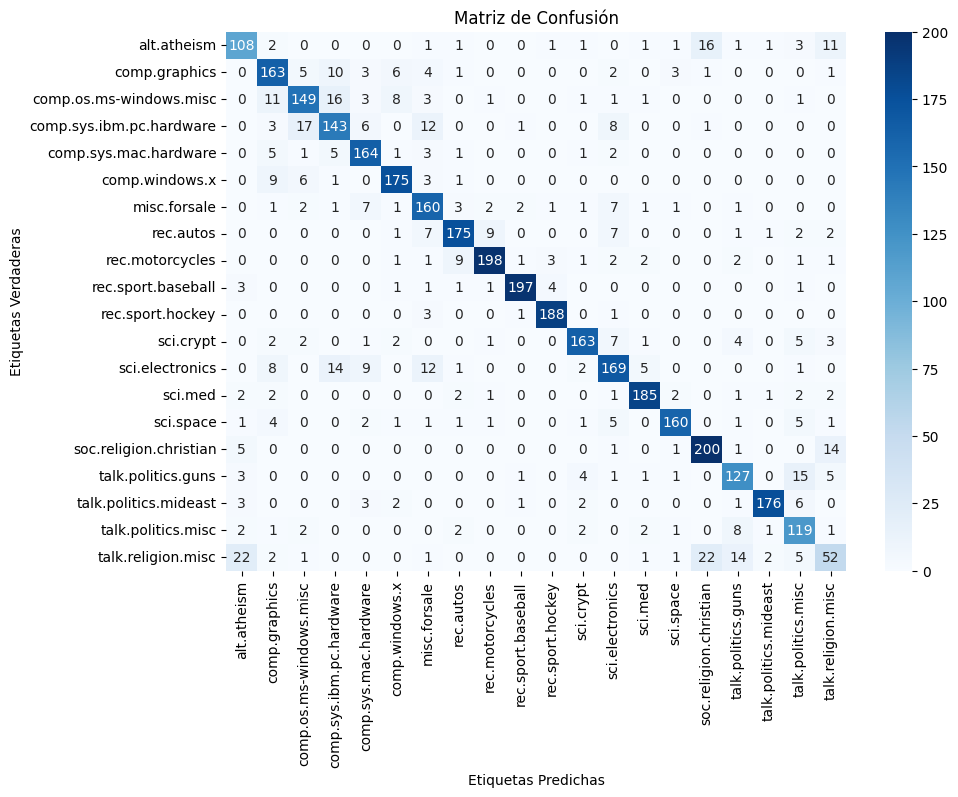

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Obtener la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)



# Crear un mapa de calor para la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
import os
output_dir = 'resultsnews/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

clsf_report = pd.DataFrame(classification_report(y_true = y_test, y_pred = y_pred, target_names=LABELS, output_dict=True)).transpose()
path_results = output_dir+model_name
TASK='20NEWS'
clsf_report.to_csv(path_results+'_{}.csv'.format(TASK), index= True)
print(path_results+'_{}.csv'.format(TASK), ' grabado!')


resultsnews/distilbert-base-uncased_20NEWS.csv  grabado!
